In [1]:
from PIL import Image
import pytesseract
from pytesseract import Output
import cv2
from pdf2image import convert_from_path,convert_from_bytes
import numpy as np
from easyocr import Reader

POPPLER_PATH = r'C:\\Users\\yashs\\Workspace\\Softwares\\poppler-0.68.0_x86\\poppler-0.68.0\\bin'
pytesseract.pytesseract.tesseract_cmd = r'C:\\Users\\yashs\\Workspace\\Softwares\\Tesseract-OCR\\tesseract'
# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

In [2]:
def get_image_from_pdf(path):
    dpi = 300
    img = convert_from_path(path, dpi=dpi, first_page=1, last_page=1, poppler_path=POPPLER_PATH)[0]
#     img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2)
#     return img
    return np.array(img)

In [3]:
pdf_path = './private_data/EK_000008.pdf'

In [4]:
img_original = get_image_from_pdf(pdf_path)

In [90]:
def custom_thresholding(img):
    kernel = np.ones((2, 2), np.uint8)
    red_mask = np.where(img[:, :, 0] > 200, 1, 0)
    blue_mask = np.where(img[:, :, 1] > 200, 1, 0)
    green_mask = np.where(img[:, :, 2] > 200, 1, 0)
    bin_img = np.logical_or.reduce((red_mask, blue_mask, green_mask)).astype(np.uint8)*255
    img = cv2.dilate(bin_img, kernel, iterations=1)
    img = cv2.erode(img, kernel, iterations=1)
    return img


image = custom_thresholding(img_original)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[INFO] 0.9294: Frec .
[INFO] 0.9999: 60
[INFO] 0.9995: PR
[INFO] 1.0000: 177
[INFO] 0.7507: DQRS
[INFO] 1.0000: 94
[INFO] 0.6273: QT
[INFO] 1.0000: 456
[INFO] 0.6274: Qrc
[INFO] 1.0000: 456
[INFO] 0.6112: ~EJES -
[INFO] 0.3354: 2
[INFO] 0.9991: Ind_
[INFO] 0.9639: QRS
[INFO] 0.6635: 44
[INFO] 0.1850: 1
[INFO] 1.0000: 138
[INFO] 0.8108: aVR
[INFO] 0.9922: II
[INFO] 0.9568: aVL
[INFO] 0.9970: V2
[INFO] 0.9505: III
[INFO] 0.8055: avr:
[INFO] 0.8148: V3
[INFO] 0.6218: Equipo:
[INFO] 0.9736: 7405'
[INFO] 0.7260: Veloc
[INFO] 0.9999: 25
[INFO] 0.2261: M
[INFO] 0.4834: 8
[INFO] 0.5973: Hiemb
[INFO] 0.2767: 10--mfmV---Prec;
[INFO] 0.1975: 410
[INFO] 0.2983: ma
[INFO] 0.6895: mV
[INFO] 0.7717: F
[INFO] 0.5411: 50~
[INFO] 0.9997: 0,5-150
[INFO] 0.7238: Az
[INFO] 0.1447: V
[INFO] 0.7897: PHO8
[INFO] 0.9868: P?


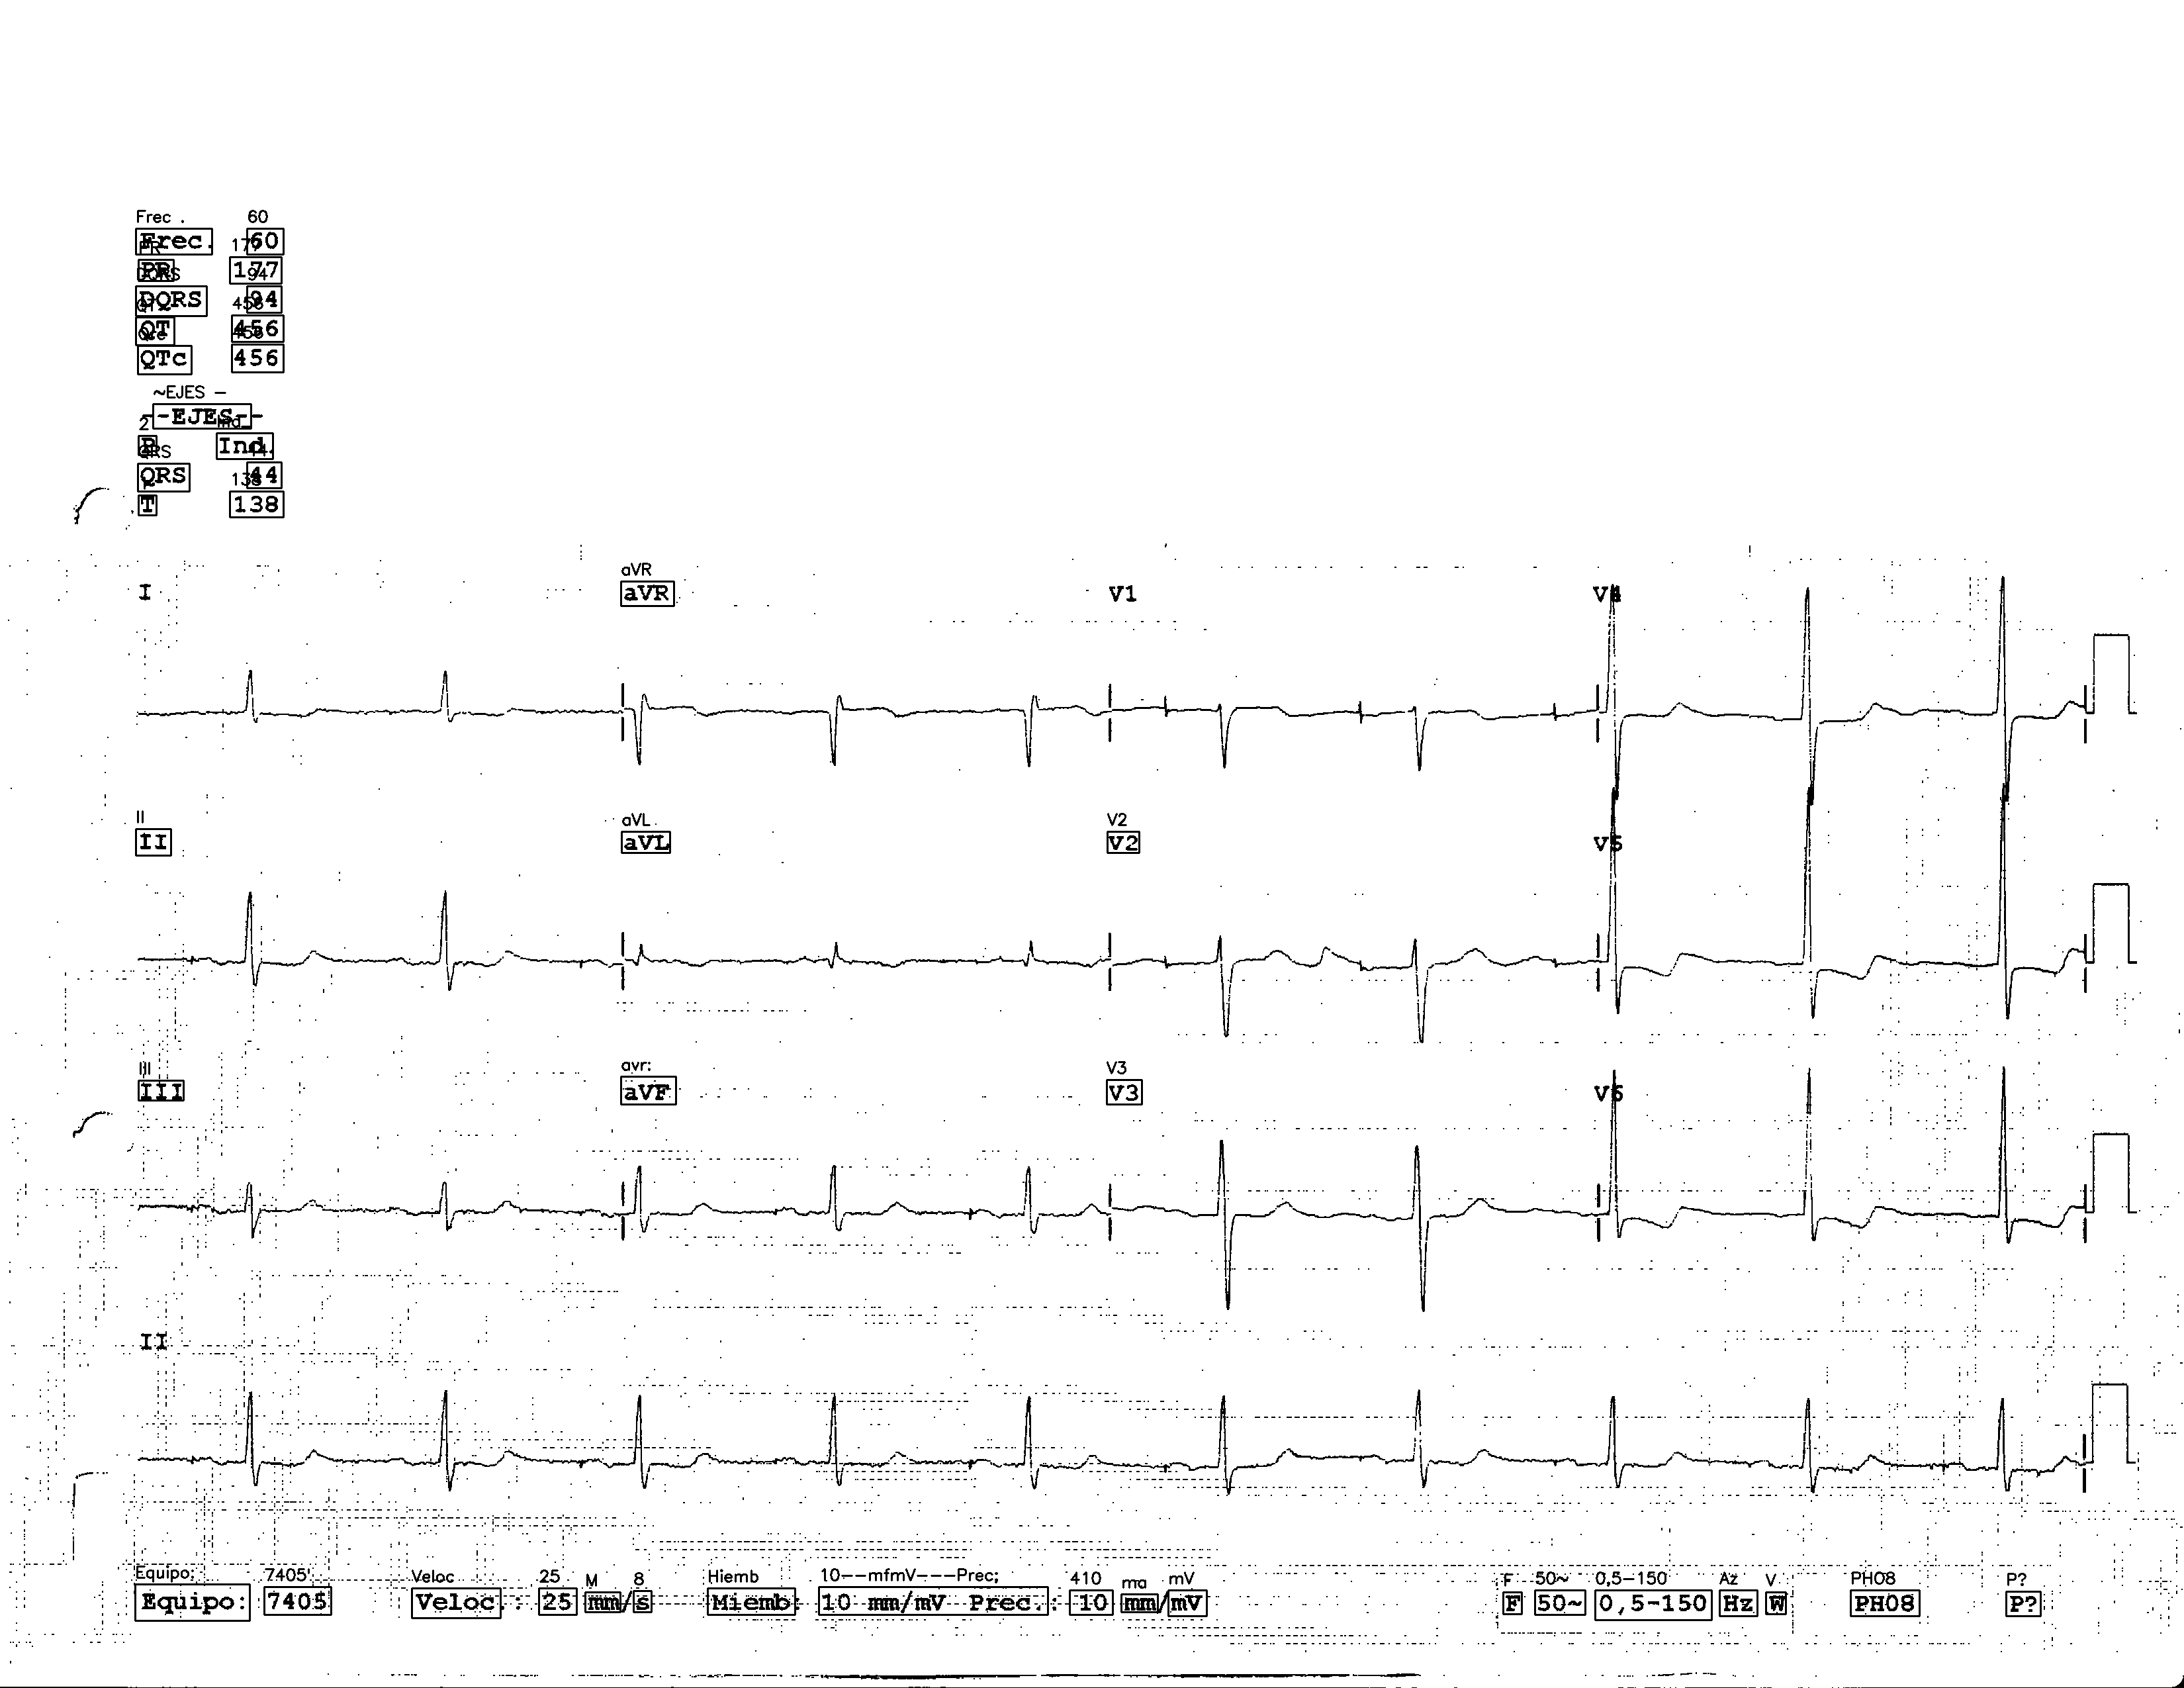

In [6]:
reader = Reader(['en'])
results = reader.readtext(image)

for (bbox, text, prob) in results:
    # display the OCR'd text and associated probability
    print("[INFO] {:.4f}: {}".format(prob, text))
    # unpack the bounding box
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    # cleanup the text and draw the box surrounding the text along
    # with the OCR'd text itself
#     text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
# show the output image

Image.fromarray(image)

In [13]:
list(x[1] for x in results)

['Frec .',
 '60',
 'PR',
 '177',
 'DQRS',
 '94',
 'QT',
 '456',
 'Qrc',
 '456',
 '~EJES -',
 '2',
 'Ind_',
 'QRS',
 '44',
 '1',
 '138',
 'aVR',
 'II',
 'aVL',
 'V2',
 'III',
 'avr:',
 'V3',
 'Equipo:',
 "7405'",
 'Veloc',
 '25',
 'M',
 '8',
 'Hiemb',
 '10--mfmV---Prec;',
 '410',
 'ma',
 'mV',
 'F',
 '50~',
 '0,5-150',
 'Az',
 'V',
 'PHO8',
 'P?']

In [42]:
crop_kb = {'h': {'h1': ('I', 'aVR', 'V1', 'V6'),
                 'h2': ('II', 'aVL', 'V2', 'V5'),
                 'h3': ('III', 'aVF', 'V3', 'V5'),
                 'h4': 'II'},
           'v': {'v1': ('I', 'II', 'III', 'II'),
                 'v2': ('aVR', 'aVL', 'aVF'),
                 'v3': ('V1', 'V2', 'V3'),
                 'v4': 'V5'}}

In [20]:
import re

In [23]:
def prep_text(s):
    s = s.lower().strip()
    regex = r"[^\w\s]"
    s = re.sub(regex, "", s)
    return s

In [78]:
from collections import OrderedDict
crop_coord = OrderedDict({
    'h':{
'h1':None, 
'h2':None, 
'h3':None, 
'h4':None
    },
    'v':{
'v1':None, 
'v2':None, 
'v3':None, 
'v4':None 
}})

In [79]:
# Horizontal
for k,pattern in crop_kb['h'].items():
    for res in results:
        for pat in map(prep_text,pattern):
            if prep_text(res[1]) == pat:
                if crop_coord['h'][k]:
                    if res[2] > crop_coord['h'][k][1]:
                        crop_coord['h'][k] = (np.array(res[0]).mean(axis=0).round().astype(int)[1],res[2])
                else:
                    crop_coord['h'][k]= (np.array(res[0]).mean(axis=0).round().astype(int)[1],res[2])
# Vertical
for k,pattern in crop_kb['v'].items():
    for res in results:
        for pat in map(prep_text,pattern):
            if prep_text(res[1]) == pat:
                if crop_coord['v'][k]:
                    if res[2] > crop_coord['v'][k][1]:
                        crop_coord['v'][k]= (np.array(res[0]).mean(axis=0).round().astype(int)[0],res[2])
                else:
                    crop_coord['v'][k]= (np.array(res[0]).mean(axis=0).round().astype(int)[0],res[2])

In [80]:
for k,hdict in crop_coord['h'].items():
    if crop_coord['h'][k]:
        crop_coord['h'][k] = crop_coord['h'][k][0]
for k,pattern in crop_coord['v'].items():
    if crop_coord['v'][k]:
        crop_coord['v'][k] = crop_coord['v'][k][0]

In [81]:

cc = crop_coord
cc

OrderedDict([('h', {'h1': 896, 'h2': 1272, 'h3': 1647, 'h4': None}),
             ('v', {'v1': 232, 'v2': 976, 'v3': 1697, 'v4': 2683})])

In [87]:
vertical_def = None
horizontal_def = None
h_buf,v_buf = None, None

for k,v in cc['h'].items():
    if v:
        if h_buf:
            horizontal_def = v - h_buf
            break
        else:
            h_buf = v
h_buf = None       
for k,v in cc['h'].items():
    if not v and h_buf:
        cc['h'][k] = h_buf + horizontal_def
    else:
        h_buf = v
            
for k,v in cc['v'].items():
    if v:
        if v_buf:
            vertical_def = v - v_buf
            break
        else:
            v_buf = v
            
for k,v in cc['h'].items():
    if not v and h_buf:
        cc['h'][k] = h_buf + horizontal_def
    else:
        h_buf = v
crop_coord,vertical_def,horizontal_def

(OrderedDict([('h', {'h1': 896, 'h2': 1272, 'h3': 1647, 'h4': 2023}),
              ('v', {'v1': 232, 'v2': 976, 'v3': 1697, 'v4': 2683})]),
 744,
 376)

In [88]:
cc = {}
for k,v in crop_coord['h'].items():
    cc[k] = v 
for k,v in crop_coord['v'].items():
    cc[k] = v 

[[232, 896], [976, 1272]]
[[976, 896], [1697, 1272]]
[[1697, 896], [2683, 1272]]
[[2683, 896], [3300, 1272]]
[[232, 2023], [3300, 2550]]
[[976, 1272], [1697, 1647]]
[[1697, 1272], [2683, 1647]]
[[2683, 1272], [3300, 1647]]
[[232, 1647], [976, 2023]]
[[976, 1647], [1697, 2023]]
[[1697, 1647], [2683, 2023]]
[[2683, 2023], [3300, 2023]]


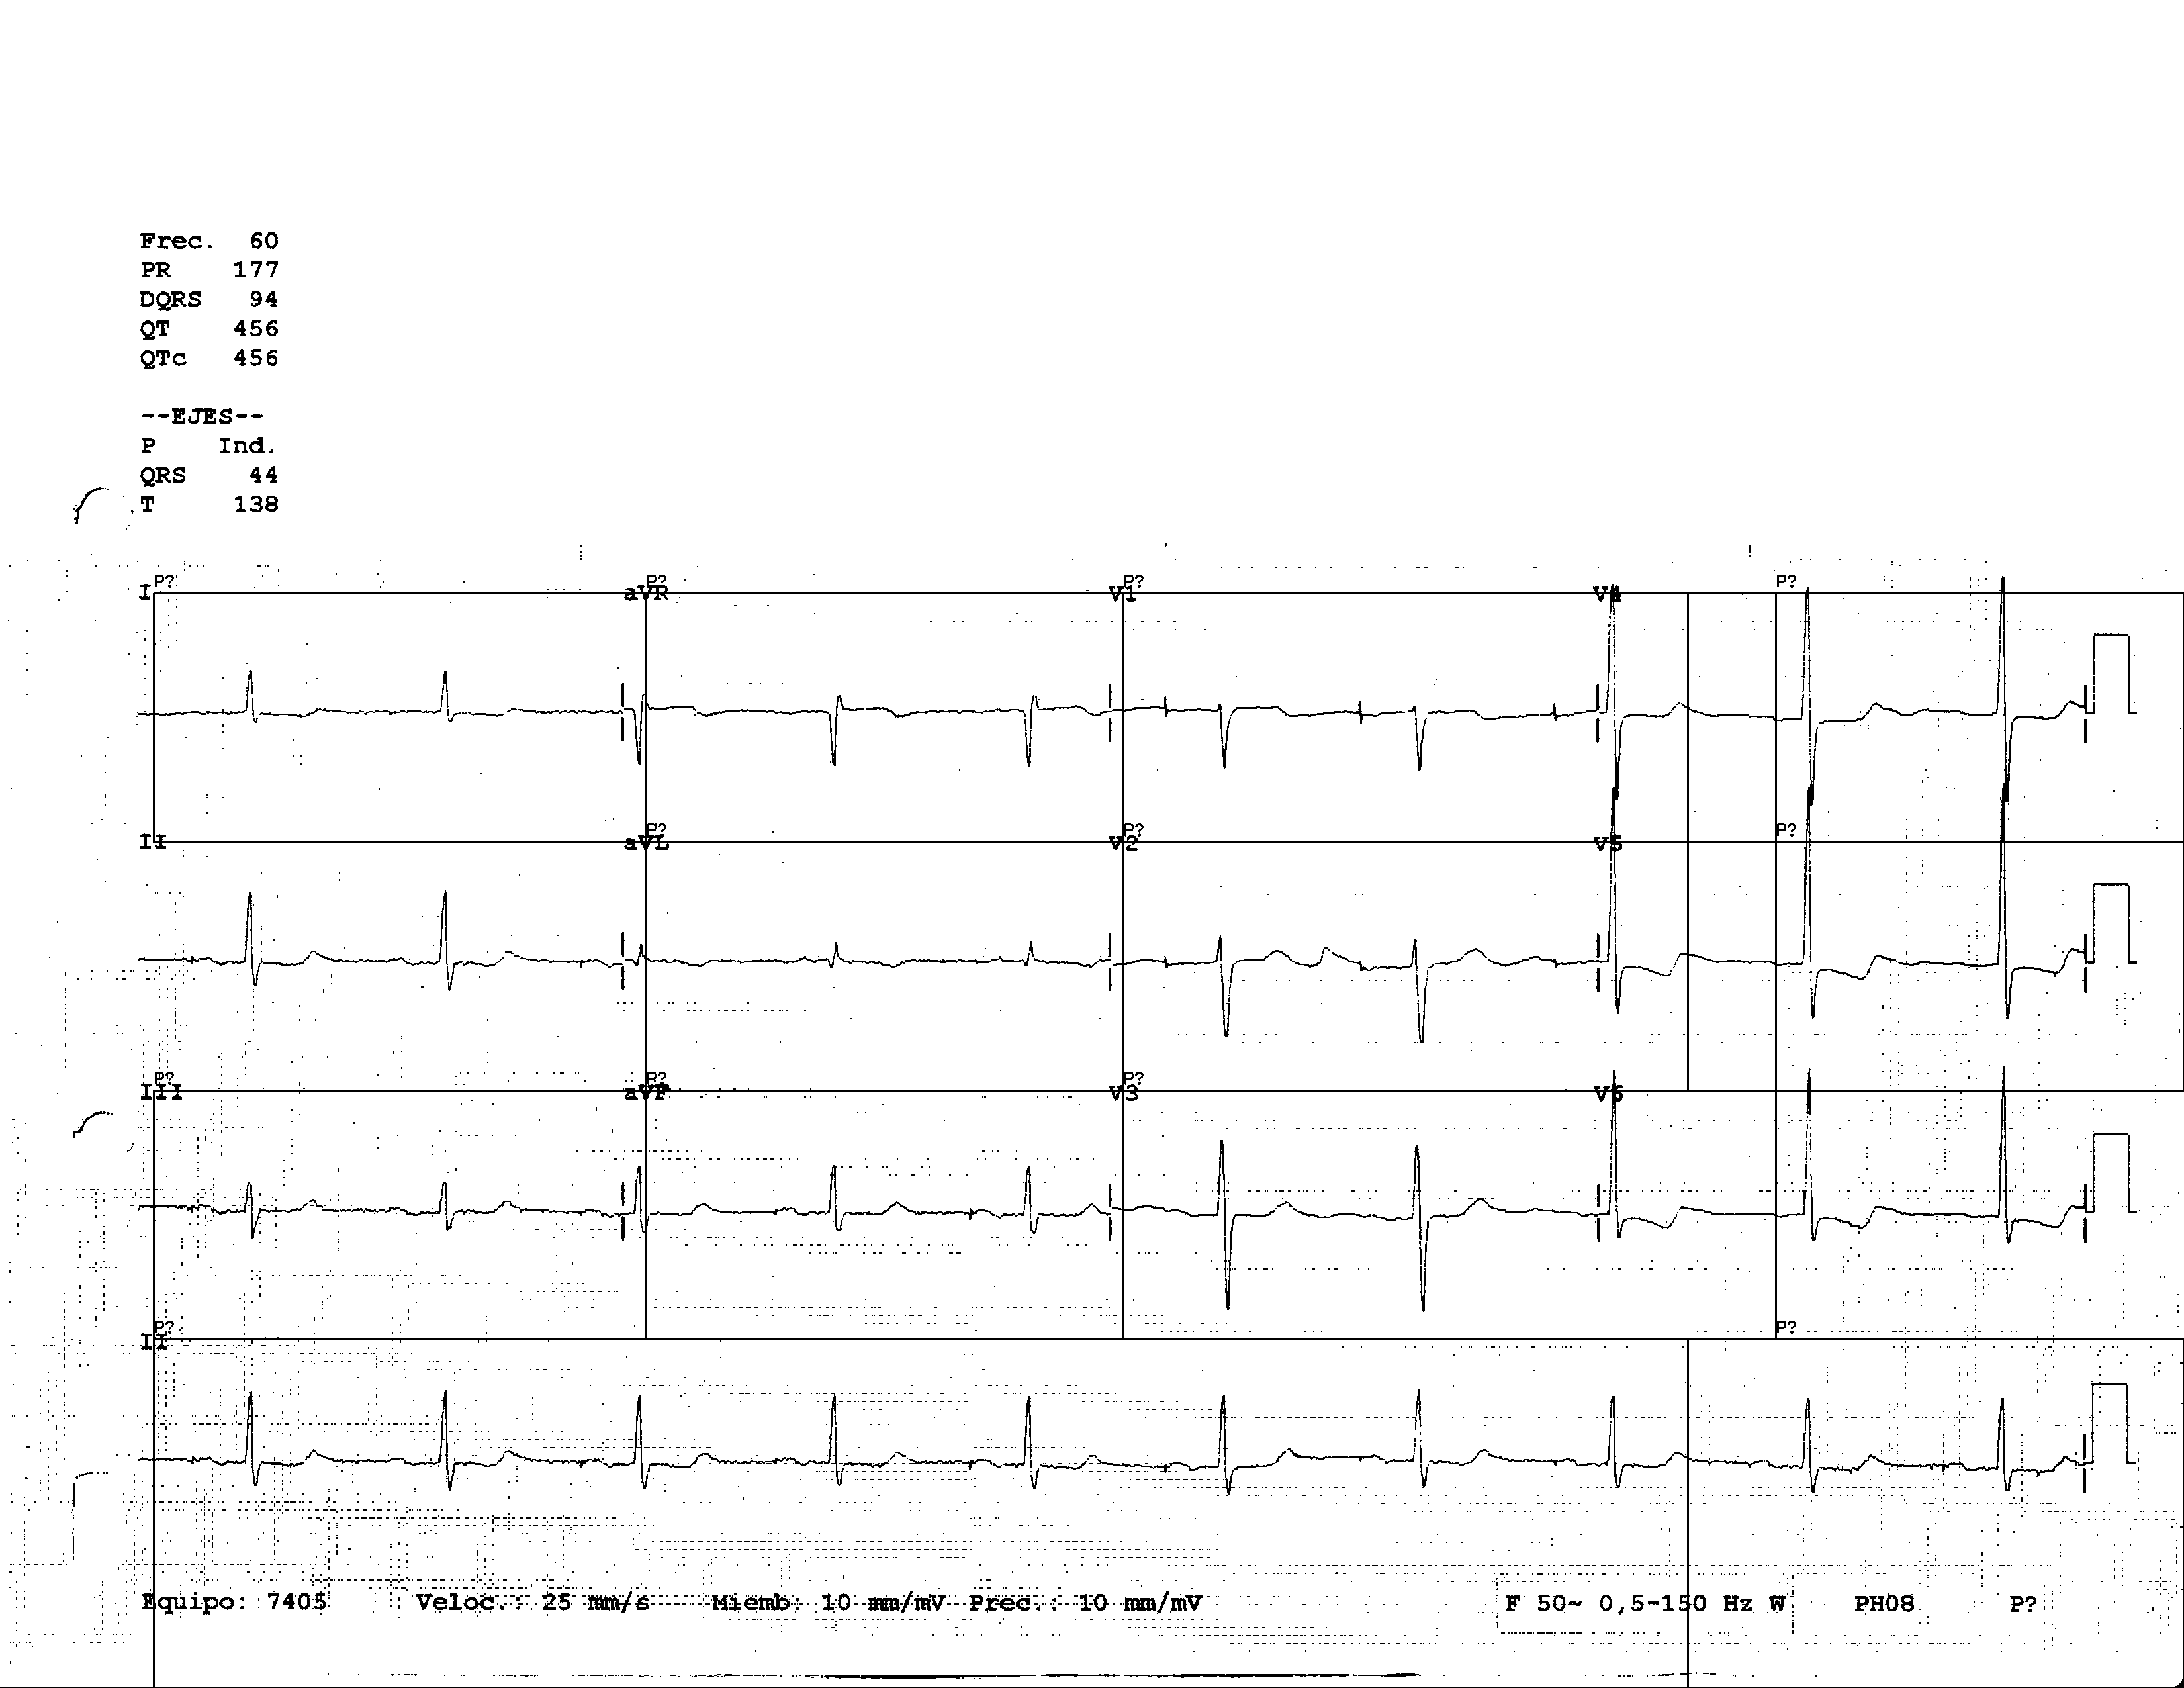

In [97]:
# tl, tr, br, bl
crop_ref = {
    'I':[[cc['v1'],cc['h1']],[cc['v2'],cc['h2']]],
    'aVR':[[cc['v2'],cc['h1']],[cc['v3'],cc['h2']]],
    'V1':[[cc['v3'],cc['h1']],[cc['v4'],cc['h2']]],
    'V4':[[cc['v4'],cc['h1']],['end',cc['h2']]],
    'II':[[cc['v1'],cc['h2']],[cc['v2'],cc['h3']]],
    'aVL':[[cc['v2'],cc['h2']],[cc['v3'],cc['h3']]],
    'V2':[[cc['v3'],cc['h2']],[cc['v4'],cc['h3']]],
    'V5':[[cc['v4'],cc['h2']],['end',cc['h3']]],
    'III':[[cc['v1'],cc['h3']],[cc['v2'],cc['h4']]],
    'aVF':[[cc['v2'],cc['h3']],[cc['v3'],cc['h4']]],    
    'V3':[[cc['v3'],cc['h3']],[cc['v4'],cc['h4']]],
    'V6':[[cc['v4'],cc['h4']],['end',cc['h4']]],
    'II':[[cc['v1'],cc['h4']],['end','end']]
}
H,W = image.shape[:2]

for k,v in crop_ref.items():
    
    tl, br = v
    if tl[0] == 'end':
        tl[0] = W
    if br[0] == 'end':
        br[0] = W
    if tl[1] == 'end':
        tl[1] = H
    if br[1] == 'end':
        br[1] = H
    print(v)
    # cleanup the text and draw the box surrounding the text along
    # with the OCR'd text itself
#     text = cleanup_text(text)
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
    cv2.putText(image, text, (tl[0], tl[1] - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
# show the output image

Image.fromarray(image)

In [106]:
def crop_img(img, bbox):
#     print(bbox)
    crop_img = img[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]
    return crop_img

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
crop_ref

{'I': [[232, 896], [976, 1272]],
 'aVR': [[976, 896], [1697, 1272]],
 'V1': [[1697, 896], [2683, 1272]],
 'V4': [[2683, 896], [3300, 1272]],
 'II': [[232, 2023], [3300, 2550]],
 'aVL': [[976, 1272], [1697, 1647]],
 'V2': [[1697, 1272], [2683, 1647]],
 'V5': [[2683, 1272], [3300, 1647]],
 'III': [[232, 1647], [976, 2023]],
 'aVF': [[976, 1647], [1697, 2023]],
 'V3': [[1697, 1647], [2683, 2023]],
 'V6': [[2683, 2023], [3300, 2023]]}

[[232, 896], [976, 1272]]
[[976, 896], [1697, 1272]]
[[1697, 896], [2683, 1272]]
[[2683, 896], [3300, 1272]]
[[232, 2023], [3300, 2550]]
[[976, 1272], [1697, 1647]]
[[1697, 1272], [2683, 1647]]
[[2683, 1272], [3300, 1647]]
[[232, 1647], [976, 2023]]
[[976, 1647], [1697, 2023]]
[[1697, 1647], [2683, 2023]]
[[2683, 2023], [3300, 2023]]


C:\Users\yashs\AppData\Local\Temp\ipykernel_48720\820263977.py:6: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.imshow(nimg,cmap='gray')
C:\Users\yashs\AppData\Local\Temp\ipykernel_48720\820263977.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


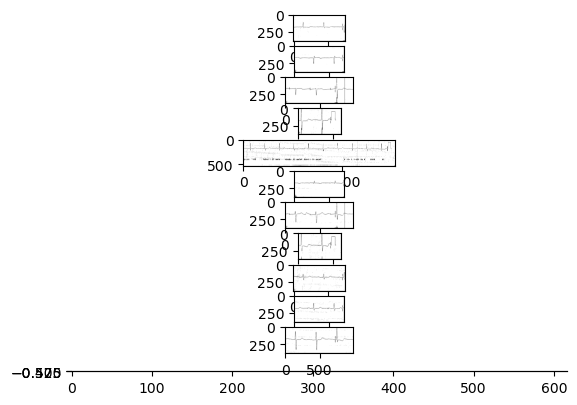

In [117]:
fig, axes = plt.subplots(12,1)

for kv,ax in zip(crop_ref.items(),axes):
    k,v = kv
    nimg = crop_img(image,v)
    ax.imshow(nimg,cmap='gray')
    
# fig.show()

In [122]:
def crop_img(img, bbox):
#     print(bbox)
    crop_img = img[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]
    return crop_img

p_img_list = []

for k,v in crop_ref.items():
    
    tl, br = v
    if tl[0] == 'end':
        tl[0] = W
    if br[0] == 'end':
        br[0] = W
    if tl[1] == 'end':
        tl[1] = H
    if br[1] == 'end':
        br[1] = H

    c_img = crop_img(img,[tl,br])
    p_img_list.append(Image.fromarray(c_img))

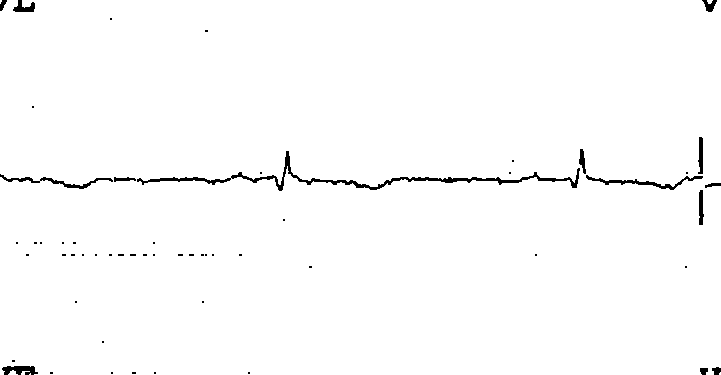

In [128]:
p_img_list[5]